<a href="https://colab.research.google.com/github/chhavi007-bit/Doctor-Patient-Conversation-Analysis-/blob/main/NLP8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

preprocessing
cleaning
and Keyword-based Emergency Detection system

In [43]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

Loading and Reading Data

In [44]:
from google.colab import files
uploaded = files.upload()

Saving gpt-4.csv to gpt-4 (1).csv


In [45]:
data = 'gpt-4.csv'
df = pd.read_csv(data , on_bad_lines='skip', quotechar='"',  delimiter=';')
df = df.head(3000)


In [46]:
print(df)

                                      data,conversation
0     This 60-year-old male was hospitalized due to ...
1         Patient: I'm feeling a bit better, thank you.
2     Doctor: I see from your clinical notes that yo...
3     Patient: Yes, I had a fever, dry cough, and di...
4     Doctor: I'm sorry to hear that. During your ho...
...                                                 ...
2995  Patient: Not really, just some occasional join...
2996  Doctor: Okay. Based on your medical history an...
2997                   Patient: Okay, that sounds good.
2998  Doctor: It's important to avoid alcohol and sm...
2999  Patient: I haven't had a drink since May 2014,...

[3000 rows x 1 columns]


Sampling

In [47]:
sample_df = df.sample(n=1000, random_state=42)
print(sample_df)

                                      data,conversation
1801                                      Patient: Yes.
1190                              Patient: Okay, I see.
1817  Doctor: Okay. It's possible that your current ...
251              Patient: I noticed it a few weeks ago.
2505  Doctor: Two years later, you came back with a ...
...                                                 ...
618   Patient: Sure. I have both conditions and I re...
406   Doctor: I'm sorry to say that it means you hav...
1157                     Patient: Yes, that's correct. 
1068              Patient: I'm feeling okay, thank you.
1133  Doctor: Of course. And if you have any concern...

[1000 rows x 1 columns]


clean data
- These characters can introduce noise and ambiguity to your data, and may not be relevant for your NLP task.

In [48]:
import re
def clean_text(text):

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

sample_df['text_column'] = sample_df['data,conversation'].apply(clean_text)
print(sample_df['text_column'])

1801                                          Patient Yes
1190                                   Patient Okay I see
1817    Doctor Okay Its possible that your current sym...
251                  Patient I noticed it a few weeks ago
2505    Doctor Two years later you came back with a ha...
                              ...                        
618     Patient Sure I have both conditions and I rece...
406     Doctor Im sorry to say that it means you have ...
1157                            Patient Yes thats correct
1068                    Patient Im feeling okay thank you
1133    Doctor Of course And if you have any concerns ...
Name: text_column, Length: 1000, dtype: object


Text Preprocessing

In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [50]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)


sample_df['processed_text'] = sample_df['text_column'].apply(preprocess_text)


In [51]:
print(sample_df['processed_text'])

1801                                          patient yes
1190                                     patient okay see
1817    doctor okay possible current symptom may relat...
251                              patient noticed week ago
2505    doctor two year later came back hacking cough ...
                              ...                        
618     patient sure condition receive hemodialysis re...
406     doctor im sorry say mean liver cancer need dis...
1157                            patient yes thats correct
1068                        patient im feeling okay thank
1133    doctor course concern experience new symptom d...
Name: processed_text, Length: 1000, dtype: object


In [52]:
sample_df['text_column'] = sample_df['text_column'].astype(str)


Exploratory Data Analysis

In [53]:
from collections import Counter
word_counts = Counter(" ".join(sample_df['processed_text']).split())
print(word_counts.most_common(10))

[('patient', 602), ('doctor', 520), ('okay', 151), ('see', 131), ('right', 130), ('yes', 129), ('day', 113), ('history', 102), ('well', 95), ('also', 88)]


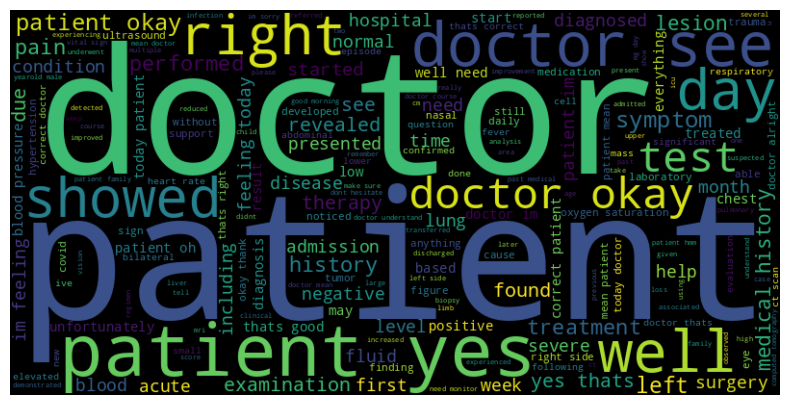

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400).generate(" ".join(sample_df['processed_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


 Sentiment Analysis using TextBlob

In [55]:
from textblob import TextBlob

def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return "positive" if sentiment > 0 else "negative" if sentiment < 0 else "neutral"

sample_df['sentiment'] = sample_df['processed_text'].apply(get_sentiment)
sentiment_counts = sample_df['sentiment'].value_counts()
print(sentiment_counts)


sentiment
positive    467
neutral     371
negative    162
Name: count, dtype: int64


<ipython-input-56-89b0ff6f2888>:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



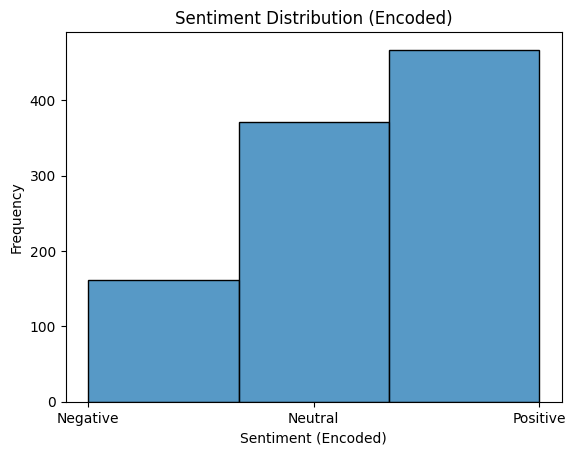

In [56]:
#Sentiment Distribution Plot
sample_df['sentiment_encoded'] = sample_df['sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})

sns.histplot(data=sample_df, x='sentiment_encoded', kde=False, bins=3, palette='husl')
plt.title('Sentiment Distribution (Encoded)')
plt.xlabel('Sentiment (Encoded)')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()

Classification Model
- Text Vectorization and Model Training
- Count Vectorizer for Feature Extraction

Accuracy: 0.785
F1 Score: 0.7707334332561203
Confusion Matrix:
 [[ 9 12  7]
 [ 0 74  4]
 [ 4 16 74]]


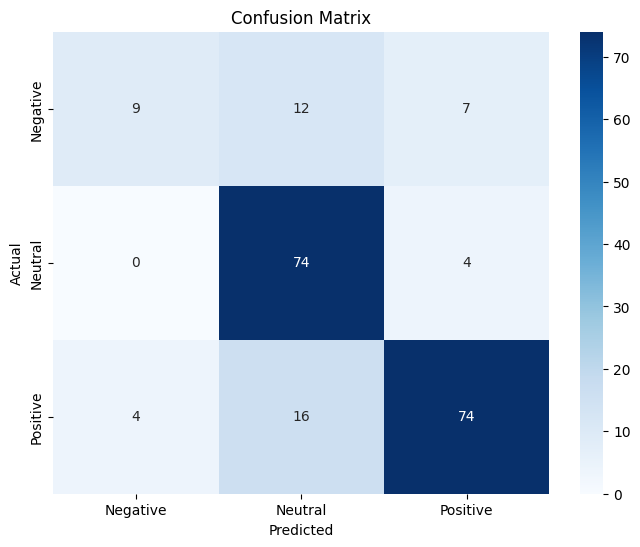

In [57]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

vectorizer = CountVectorizer(max_features=9000)
X = vectorizer.fit_transform(sample_df['processed_text']).toarray()
y = sample_df['sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Negative Word Extraction


In [58]:
def extract_negative_words_from_dataset(df, negative_keywords):


    # Filter rows with negative sentiment
    negative_rows = df[df['sentiment'] == 'negative']

    # Extract negative words
    negative_words_list = []

    for text in negative_rows['text_column']:
        words = text.lower().split()
        negative_words = [word for word in words if word in negative_keywords]
        negative_words_list.append(negative_words)

    # Add extracted words to a new column
    negative_rows['negative_words'] = negative_words_list

    # Changed from 'text' to 'text_column'
    return negative_rows[['text_column', 'negative_words']]

# Define a set of negative keywords
negative_keywords = {
    'terrible', 'alarming', 'bad', 'worse', 'worst',
    'dangerous', 'critical', 'urgent', 'harm', 'risk',
    'failure', 'emergency', 'problem', 'issue', 'disaster', 'pain', 'unbearable',
    'critical', 'urgent', 'ineffective', 'severe', 'deteriorating',
    'blurry', 'symptoms', 'condition',

    # Symptoms and Conditions
    'headache', 'fever', 'nausea', 'dizziness', 'vomiting', 'bleeding',
    'swelling', 'infection', 'rash', 'fatigue', 'fainting', 'shortness of breath',
    'breathing difficulty', 'blurred vision', 'chest pain', 'weakness', 'numbness',
    'tingling',

    # Emotional and Psychological
    'anxious', 'worried', 'scared', 'fear', 'panic', 'concern', 'crying', 'hopeless',

    # Urgent Situations
    'urgent', 'immediate', 'emergency', 'life-threatening', 'danger', 'risk',
    'collapse', 'unconscious', 'faint',

    # Medication and Treatment Issues
    'side effect', 'reaction', 'ineffective', 'overdose', 'allergic', 'complication',
    'wrong dosage', 'error',

    # Diagnostic Terms
    'abnormal', 'test result', 'abnormality', 'irregular', 'abnormal levels'

}

negative_words_df = extract_negative_words_from_dataset(sample_df, negative_keywords)
print(negative_words_df)

                                            text_column negative_words
2579  Patient Ive been feeling more tired and short ...             []
2738  Doctor And when you were diagnosed with strang...             []
2083  Doctor Im sorry to hear that you were found un...  [unconscious]
2603  Doctor The CT scan also detected a periaortic ...             []
2851                  Patient Yes it means he has COVID             []
...                                                 ...            ...
1125  Doctor I see And none of the gene fusions were...   [risk, risk]
2650  Doctor Unfortunately the results of the CTPA s...             []
2761         Patient Hmm Im feeling okay a little tired             []
1808  Doctor Im sorry to inform you that despite our...    [condition]
406   Doctor Im sorry to say that it means you have ...             []

[162 rows x 2 columns]


<ipython-input-58-0867f1df47c3>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



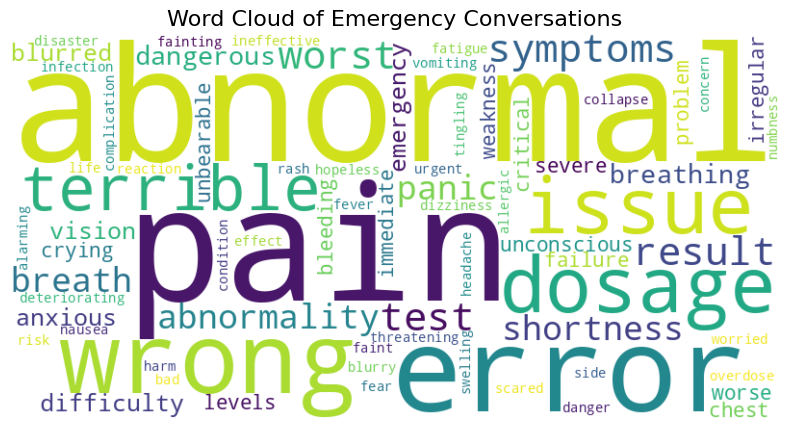

In [59]:
# Combine all emergency texts into one string
emergency_text_combined = " ".join(negative_keywords)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emergency_text_combined)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Emergency Conversations', fontsize=16)
plt.show()


prediction for Emergency Conversations

In [60]:
def emergency_check(text):


    # Check for alarming keywords
    if any(word in text.lower() for word in negative_keywords):
        return "Emergency Alert: Alarming situation detected!"

    # Use the vectorizer and model for prediction

        text_vector = t_vectorizer.transform([text])
        sentiment = model.predict(text_vector)

        # Check sentiment (assuming 0 = Negative)
        if sentiment[0] == 0:
            return "Emergency Alert: Negative sentiment detected!"
        else:
            return "No emergency detected."


    return "No emergency detected."


Emergency Check : message

In [61]:
emergency_check("The situation is terrible and alarming.")


'Emergency Alert: Alarming situation detected!'

In [62]:
emergency_check("I'm extremely worried about my condition. The symptoms seem to be getting worse, and I feel like my health is deteriorating.")

'Emergency Alert: Alarming situation detected!'

In [63]:
emergency_check("Doctor, I’m experiencing a critical issue with my breathing. It feels like I’m running out of air frequently.")

'Emergency Alert: Alarming situation detected!'

In [64]:
emergency_check("The medication you prescribed last time helped significantly. I feel much better now, thank you!")

'No emergency detected.'

In [65]:
emergency_check(
        "The situation is urgent. I’ve been having severe headaches, and my vision has become blurry in the past few days."
   )

'Emergency Alert: Alarming situation detected!'

In [66]:
emergency_check("The medication caused a severe reaction, and I’m feeling worse.")

'Emergency Alert: Alarming situation detected!'

**DASHBOARD**

In [67]:
!pip install dash dash-bootstrap-components plotly pandas

In [68]:
!pip install dash dash-bootstrap-components plotly pandas
# Import necessary libraries
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.graph_objects as go
import base64
from io import BytesIO
from wordcloud import WordCloud
# ... (rest of your code)

In [69]:


# Generate Overall Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(sample_df['processed_text']))
img = BytesIO()
wordcloud.to_image().save(img, format='PNG')
wordcloud_base64 = base64.b64encode(img.getvalue()).decode()

# Generate Negative Word Cloud
negative_wordcloud = WordCloud(
    width=800, height=400, background_color='black'
).generate(" ".join([word for text in sample_df['processed_text'] for word in text.split() if word in negative_keywords]))
negative_img = BytesIO()
negative_wordcloud.to_image().save(negative_img, format='PNG')
negative_wordcloud_base64 = base64.b64encode(negative_img.getvalue()).decode()

# High-Risk Conversations Gauge
total_conversations = len(sample_df)
high_risk_count = sum(1 for text in sample_df['text_column'] if any(word in text.lower() for word in negative_keywords))
high_risk_percentage = (high_risk_count / total_conversations) * 100
gauge_fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=high_risk_percentage,
    title={'text': "High-Risk Conversations (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "red"},
        'steps': [
            {'range': [0, 50], 'color': "lightgreen"},
            {'range': [50, 75], 'color': "yellow"},
            {'range': [75, 100], 'color': "red"},
        ],
    }
))

# Sentiment Distribution
sentiment_fig = px.histogram(
    sample_df,
    x='sentiment',
    color='sentiment',
    title="Sentiment Distribution",
    labels={"sentiment": "Sentiment", "count": "Frequency"}
)

# High-Risk Keyword Bar Chart
high_risk_keywords = []
for text in sample_df['text_column']:
    words = text.lower().split()
    high_risk_keywords += [word for word in words if word in negative_keywords]

keyword_counts = pd.DataFrame(Counter(high_risk_keywords).most_common(), columns=['Keyword', 'Frequency'])
keyword_bar_chart = px.bar(
    keyword_counts.head(20),
    x='Keyword',
    y='Frequency',
    title='Top 20 High-Risk Keywords',
    labels={'Frequency': 'Count of Occurrences', 'Keyword': 'High-Risk Keywords'},
    text='Frequency'
)
keyword_bar_chart.update_traces(textposition='outside')

# Confusion Matrix
confusion_matrix_fig = go.Figure(data=go.Heatmap(
    z=[[50, 10, 5], [8, 60, 7], [4, 9, 70]],
    x=['Negative', 'Neutral', 'Positive'],
    y=['Negative', 'Neutral', 'Positive'],
    colorscale='Blues',
    texttemplate="%{z}",
    showscale=True
)).update_layout(title="Confusion Matrix", xaxis_title="Predicted", yaxis_title="Actual")

# Initialize Dash App
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    html.H1("Emergency Text Analysis Dashboard", className="text-center mb-4"),
    dcc.Dropdown(
        id="visualization-selector",
        options=[
            {"label": "Patient Risk Analyzer", "value": "analyzer"},
            {"label": "Overall Word Cloud", "value": "wordcloud"},
            {"label": "Negative Word Cloud", "value": "negative_wordcloud"},
            {"label": "High-Risk Gauge", "value": "gauge"},
            {"label": "Sentiment Distribution", "value": "sentiment"},
            {"label": "High-Risk Keywords", "value": "keywords"},
            {"label": "Confusion Matrix", "value": "confusion_matrix"}
        ],
        placeholder="Select a visualization",
        className="mb-4"
    ),
    html.Div(id="visualization-content")
])

@app.callback(
    Output("visualization-content", "children"),
    Input("visualization-selector", "value"),
    State("visualization-content", "children")
)
def update_visualization(selected_visualization,current_children):
    if selected_visualization == "wordcloud":
        return html.Img(src=f"data:image/png;base64,{wordcloud_base64}", style={"width": "100%"})
    elif selected_visualization == "negative_wordcloud":
        return html.Img(src=f"data:image/png;base64,{negative_wordcloud_base64}", style={"width": "100%"})
    elif selected_visualization == "gauge":
        return dcc.Graph(figure=gauge_fig)
    elif selected_visualization == "sentiment":
        return dcc.Graph(figure=sentiment_fig)
    elif selected_visualization == "keywords":
        return dcc.Graph(figure=keyword_bar_chart)
    elif selected_visualization == "confusion_matrix":
        return dcc.Graph(figure=confusion_matrix_fig)
    elif selected_visualization == "analyzer":
        return dbc.Row([
            dbc.Col([
                dbc.Input(id='text-input', placeholder="Enter text here...", type="text", className="mb-2"),
                dbc.Button("Analyze Risk", id='analyze-button', color="primary", className="mb-2"),
                html.Div(id='risk-output', className="mt-2")
            ], width=12),
        ])
    return html.Div("Please select a visualization from the dropdown.")

@app.callback(
    Output('risk-output', 'children'),
    Input('analyze-button', 'n_clicks'),
    State('text-input', 'value')
)
def analyze_risk(n_clicks, input_text):
    if n_clicks and input_text:
        if any(word in input_text.lower() for word in negative_keywords):
            return dbc.Alert("High Risk Detected: Emergency Alert!", color="danger")
        else:
            return dbc.Alert("Low Risk: No Emergency Detected.", color="success")
    return

if __name__ == "__main__":
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [70]:
print(negative_keywords)

{'error', 'wrong dosage', 'issue', 'terrible', 'symptoms', 'worst', 'test result', 'abnormality', 'shortness of breath', 'panic', 'dangerous', 'breathing difficulty', 'emergency', 'anxious', 'blurred vision', 'unconscious', 'crying', 'abnormal levels', 'problem', 'irregular', 'chest pain', 'worse', 'failure', 'abnormal', 'critical', 'immediate', 'bleeding', 'severe', 'unbearable', 'weakness', 'deteriorating', 'overdose', 'fainting', 'fear', 'swelling', 'fatigue', 'worried', 'ineffective', 'life-threatening', 'side effect', 'rash', 'urgent', 'complication', 'tingling', 'bad', 'risk', 'nausea', 'vomiting', 'dizziness', 'infection', 'scared', 'concern', 'collapse', 'harm', 'hopeless', 'disaster', 'allergic', 'reaction', 'pain', 'condition', 'numbness', 'alarming', 'fever', 'danger', 'blurry', 'headache', 'faint'}


In [71]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client


In [72]:
from google.colab import files
uploaded = files.upload()



In [73]:
CLIENT_SECRETS_FILE = list(uploaded.keys())[0]
print("Using file:", CLIENT_SECRETS_FILE)


IndexError: list index out of range

In [ ]:
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
import pickle
import os

# Define the scope for Google Calendar API
SCOPES = ['https://www.googleapis.com/auth/calendar']

# Path to the client secrets JSON file
# Updated to use the filename from 'uploaded' if available
CLIENT_SECRETS_FILE = list(uploaded.keys())[0] if uploaded else '/mnt/data/client_secret_442294912982-kuiodk9pol9a6sq4rlekdam6h5m9cu99.apps.googleusercontent.com.json'
print("Using file:", CLIENT_SECRETS_FILE) # for Debugging. comment after fix

def authenticate_google_calendar():
    creds = None
    # Token storage for re-use
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)

    # If no valid credentials, go through the OAuth flow
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            # Explicitly set the redirect URI for Colab
            flow.redirect_uri = 'https://accounts.google.com/o/oauth2/auth'
            auth_url, _ = flow.authorization_url(prompt='consent')

            print('Please go to this URL and grant the permissions:')
            print(auth_url)

            # Get the authorization code from the user
            code = input('Enter the authorization code: ')
            flow.fetch_token(code=code) # The error occurs here if the code is invalid.
            creds = flow.credentials

        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    return creds

# Authenticate and build the Calendar API service
creds = authenticate_google_calendar()
service = build('calendar', 'v3', credentials=creds)

# Example: List available calendars
calendar_list = service.calendarList().list().execute()
print("Available Calendars:")
for calendar in calendar_list['items']:
    print(f"- {calendar['summary']} ({calendar['id']})")

# Example: Create a new event
event = {
    'summary': 'Follow-Up Meeting',
    'location': 'Virtual',
    'description': 'Discussion about patient high-risk keywords.',
    'start': {
        'dateTime': '2025-01-25T10:00:00-07:00',  # Replace with desired time
        'timeZone': 'America/Los_Angeles',
    },
    'end': {
        'dateTime': '2025-01-25T11:00:00-07:00',  # Replace with desired time
        'timeZone': 'America/Los_Angeles',
    },
    'attendees': [
        {'email': 'example@example.com'},  # Replace with recipient email
    ],
    'reminders': {
        'useDefault': False,
        'overrides': [
            {'method': 'email', 'minutes': 24 * 60},
            {'method': 'popup', 'minutes': 10},
        ],
    },
}

event_result = service.events().insert(calendarId='primary', body=event).execute()
print(f"Event created: {event_result.get('htmlLink')}")

# Generate the authorization URL
# auth_url, _ = flow.authorization_url(prompt='consent')
authorization_url = (
    "https://accounts.google.com/o/oauth2/auth"
    "?client_id=YOUR_CLIENT_ID"
    "&redirect_uri=YOUR_REDIRECT_URI"
    "&scope=YOUR_SCOPES"
    "&response_type=code"
)



# Print the URL for manual authorization
print("Go to the following URL to authorize the application:")
print(auth_url)

# Paste the authorization code below
auth_code = input("Enter the authorization code: ")

# Complete the flow with the authorization code
creds = flow.fetch_token(code=auth_code)

print("Authorization successful!")